In [49]:
import numpy as np # library to handle data in a vectorized manner
import time
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import folium # map rendering library
from folium import plugins

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans



print('Libraries imported.')


Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


# 1. Introduction

### 1.1 Background

Hello. I am an aspiring Data Analyst living in Singapore. I am currently working for a British MNC in Ang Mo Kio (North Eastern part of Singapore).
I have been offered a wonderful opportunity to work as a Data Analyst in a prominent IT firm located at Telok Blangah (Southern ridges in Singapore). I am very excited and will like to use this opportunity to practice my learnings in Coursera.
I will like to make a comparision of food choices between these 2 locations using the methods taught to me in this course.
Here are my set criteria:
1) Meals must not exceed SGD 5.00
2) Meals location must be within 15 mins walking duration
3) Preferred locations include Hawker centres, Coffee Shops, Canteens.

### 1.2 Problem Statement

To find an economical meal option located in near vincity to my work location in Telok Blangah.
The data required to resolve this challenge will be described in the following section.

### 1.3 To whom it might concern

This study might be relatable to any person or entity considering working or moving from North East Singapore to Southern Singapore.

This model can also be used to look across all other regions in Singapore. Lastly, this project is a good practical case toward the development of Data Science skills.

# 2. Data Section

### 2.1 Description of the Data

1) List of Sub-neighborhoods of Telok Blangah with their geodata (latitude and longitude)

2) List of Bus Stops in Telok Blangah with their address location.

3) List of Hawker Centre and Coffee shops in Telok Blangah with their addresses and average price.

# 3. Methodology Section

This section will show case the main portion of data preperation and analysis. 

The strategy is based on mapping the above described data in section 2.0, in order to facilitate the choice of at least two candidate places for rent. The choice is made based on the demands imposed : location near a subway, rental price and similar venues to Singapore. This visual approach and maps with popups labels allow quick identification of location, price and feature, thus making the selection very easy.
The procesing of these DATA and its mapping will allow to answer the key questions to make a decision:
what is the cost of available rental places that meet the demands?

- what is the cost of meal around a 10 min walking radius from each subway metro station?
- what is the area of Telok Blangah with best meal pricing that meets criteria established?
- What are the venues of the two best places to eat? How the prices compare?
- Are there tradeoffs between Distance and Price and location?

### 3.1 Execution

#### Ang Mo Kio VS Telok Blangah

In [51]:
# Ang Mo Kio, District 01, Singapore
address = 'Ang Mo Kio Industrial Park 1, Singapore'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Ang Mo Kio are {}, {}.'.format(latitude, longitude))

/Users/harold-ashleys_macbookair/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


GeocoderTimedOut: Service timed out

In [55]:
neighborhood_latitude=1.3590576
neighborhood_longitude=103.856245620364

### 3.1.1 Dial FourSquare to find meal venues around current residnece in Singapore

In [56]:
# @hidden_cell
CLIENT_ID = 'V2P0XFWDFXYJO1XHKS33V5RRKNM4SGIF0OAMON1L1FESUBDK' # your Foursquare ID
CLIENT_SECRET = '1TLEPHXN5TPQ5L5LQ3Q2AVO1VE0NFMWN3RPKTM4GJ44BUIUW' # your Foursquare Secret
VERSION = '20190511' # Foursquare API version

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID
#print('CLIENT_SECRET:' + CLIENT_SECRET)

In [57]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius
CATEGORY_ID = '4d4b7105d754a06374d81259'

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&category_id={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    CATEGORY_ID,
    neighborhood_latitude,
    neighborhood_longitude,
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=V2P0XFWDFXYJO1XHKS33V5RRKNM4SGIF0OAMON1L1FESUBDK&client_secret=1TLEPHXN5TPQ5L5LQ3Q2AVO1VE0NFMWN3RPKTM4GJ44BUIUW&v=20190511&category_id=4d4b7105d754a06374d81259&ll=1.3590576,103.856245620364&radius=1000&limit=100'

In [58]:
# results display is hidden for report simplification 
results = requests.get(url).json()
#results

Function that extracts the catergory of the venue <br>
*(Details are taken from FourSquare Lab)*

In [59]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [60]:
venues = results['response']['groups'][0]['items']

amk_venues = json_normalize(venues) # flatten JSON
# filter columns

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
amk_venues =amk_venues.loc[:, filtered_columns]

# filter the category for each row
amk_venues['venue.categories'] = amk_venues.apply(get_category_type, axis=1)

# clean columns
amk_venues.columns = [col.split(".")[-1] for col in amk_venues.columns]

amk_venues.shape

(33, 4)

In [61]:
# Venues near current Ang Mo Kio Working place
amk_venues.head()

,name,categories,lat,lng
0,Bangkok Street Mookata,BBQ Joint,1.365688,103.853186
1,Kian Seng Seafood Restaurant 建成海鲜馆,Chinese Restaurant,1.358802,103.854696
2,Bishan Sports Hall,Stadium,1.356865,103.849089
3,Bishan Swimming Complex,Pool,1.354225,103.850448
4,Eng Ho Fried Hokkien Prawn Mee,Asian Restaurant,1.362670,103.855552


In [62]:
# Exporting dataframe to excel
amk_venues.to_excel(r'/Users/harold-ashleys_macbookair/Desktop/amk_venues.xlsx')

In [63]:
latitude=1.3580
longitude=103.8563
# create map of Ang Mo Kio  using latitude and longitude values
map_amk = folium.Map(location=[latitude, longitude], zoom_start=18)
# add markers to map
for lat, lng, label in zip(amk_venues['lat'], amk_venues['lng'], amk_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=30,
        radius=7,
        popup=label,
        color='blue',
        fill_color='#0f0f0f',
        fill_opacity=0.6,
    ).add_to(map_amk)  
    
map_amk

### 3.1.2 Telok Blangah Neighbourhood - Data Mapping

In [64]:
# @hidden_cell
CLIENT_ID = 'V2P0XFWDFXYJO1XHKS33V5RRKNM4SGIF0OAMON1L1FESUBDK' # your Foursquare ID
CLIENT_SECRET = '1TLEPHXN5TPQ5L5LQ3Q2AVO1VE0NFMWN3RPKTM4GJ44BUIUW' # your Foursquare Secret
VERSION = '20190511' # Foursquare API version

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

In [65]:
# Telok Blangah, Singapore
address = 'Depot Road, Singapore'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Telok Blangah are {}, {}.'.format(latitude, longitude))

/Users/harold-ashleys_macbookair/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


GeocoderTimedOut: Service timed out

In [66]:
neighborhood_latitude_tb=1.280534
neighborhood_longitude_tb=103.8167726

In [67]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
CATEGORY_ID = '4d4b7105d754a06374d81259'

# create URL
url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&category_id={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    CATEGORY_ID,
    neighborhood_latitude_tb, 
    neighborhood_longitude_tb, 
    radius, 
    LIMIT)
url2 # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=V2P0XFWDFXYJO1XHKS33V5RRKNM4SGIF0OAMON1L1FESUBDK&client_secret=1TLEPHXN5TPQ5L5LQ3Q2AVO1VE0NFMWN3RPKTM4GJ44BUIUW&v=20190511&category_id=4d4b7105d754a06374d81259&ll=1.280534,103.8167726&radius=500&limit=100'

In [68]:
results_tb = requests.get(url2).json()
#results

In [69]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
venues = results_tb['response']['groups'][0]['items']

In [70]:
tb_venues = json_normalize(venues) 

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
tb_venues =tb_venues.loc[:, filtered_columns]

tb_venues['venue.categories'] = tb_venues.apply(get_category_type, axis=1)

tb_venues.columns = [col.split(".")[-1] for col in tb_venues.columns]

tb_venues.shape

(26, 4)

In [71]:
# Venues near current Telok Blangah Working place
tb_venues.head()

,name,categories,lat,lng
0,Coffee Bandits,Food Truck,1.281315,103.818759
1,Telok Blangah Crescent Market & Food Centre,Food Court,1.277206,103.818720
2,Swimming Pool @ SAFRA Mount Faber,Pool,1.277284,103.817672
3,Hai Kee Teochew Cha Kuay Teow 海记潮州炒粿条,Chinese Restaurant,1.277222,103.818762
4,EnergyOne Mount Faber,Gym,1.277534,103.817453


In [23]:
latitude=neighborhood_latitude_tb
longitude=neighborhood_longitude_tb

# create map of Telok Blangah  using latitude and longitude values
map_tb = folium.Map(location=[latitude, longitude], zoom_start=18)
# add markers to map
for lat, lng, label in zip(tb_venues['lat'], tb_venues['lng'], tb_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=30,
        radius=7,
        popup=label,
        color='blue',
        fill_color='#0f0f0f',
        fill_opacity=0.6,
    ).add_to(map_tb)  
    
map_tb

In [72]:
# Exporting dataframe to excel
tb_venues.to_excel(r'/Users/harold-ashleys_macbookair/Desktop/tb_venues.xlsx')

## 3.2 Data Visualization

Because meal prices in Singapore are not readily available in Foursquare API, the prices will have to be manually added via excel spreadsheet.

In [73]:
# importing back edited dataframes
tb_venue1 = pd.read_excel(r'/Users/harold-ashleys_macbookair/Desktop/Capstone project/tb_venues.xlsx')

tb_venue1.head(30)

,name,categories,lat,lng,Avg Price per Meal
0,Coffee Bandits,Food Truck,1.281315,103.818759,6
1,Telok Blangah Crescent Market & Food Centre,Food Court,1.277206,103.818720,4
2,Hai Kee Teochew Cha Kuay Teow 海记潮州炒粿条,Chinese Restaurant,1.277222,103.818762,4
3,Coffee Express 2000,Coffee Shop,1.282996,103.816513,4
4,SAFRA Mount Faber,Club House,1.277414,103.817292,6
5,The Bakery Chef,Café,1.284096,103.816268,3
6,Bukit Merah Central Food Centre,Food Court,1.283536,103.817083,4
7,McDonald's,Fast Food Restaurant,1.283803,103.818099,10
8,KFC,Fast Food Restaurant,1.284164,103.817323,8
9,Dandelion,Ice Cream Shop,1.283630,103.816491,3


In [78]:
amk_venue1 = pd.read_excel(r'/Users/harold-ashleys_macbookair/Desktop/Capstone project/amk_venues.xlsx')

amk_venue1.head(30)

,name,categories,lat,lng,Avg Price Per Meal
0,Bangkok Street Mookata,BBQ Joint,1.365688,103.853186,10
1,Kian Seng Seafood Restaurant 建成海鲜馆,Chinese Restaurant,1.358802,103.854696,5
2,Eng Ho Fried Hokkien Prawn Mee,Asian Restaurant,1.362670,103.855552,5
3,Blk 409 AMK Market & Food Centre,Market,1.362892,103.855344,4
4,GHK 407 Food House,Food Court,1.362622,103.855580,4
5,AMK 408 Food House,Food Court,1.362522,103.854887,4
6,Tian Tian Dao Hokkien Fried Noodles 天天到福建炒虾面,Chinese Restaurant,1.367884,103.856683,5
7,Chong Boon Market & Food Centre,Food Court,1.368045,103.856272,4
8,332 Coffee House,Food Court,1.362320,103.851897,4
9,Han Jiang Fish Soup,Soup Place,1.362621,103.855264,5


We will use graphical method to view what is the breakdown of prices for both location. 
Lets take a look choices available at Telok Blangah. The second distribution plot will show case break down for choices in Ang Mo Kio.

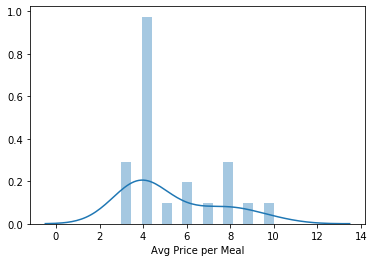

In [76]:
import seaborn as sns
sns.distplot(tb_venue1['Avg Price per Meal'],bins=15)

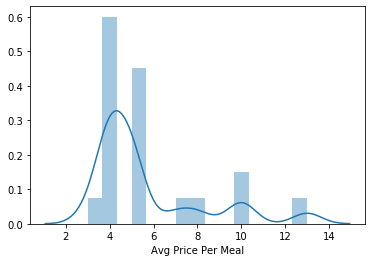

In [79]:
import seaborn as sns
sns.distplot(amk_venue1['Avg Price Per Meal'],bins=15)

From distribution chart above, we can see that both location offer similar meal prices. 
Majority of the cost lies at the SGD 4 mark

Next, lets try to check out the distance of bus stops to central location.

In [80]:
# importing back edited dataframes
tb_venue1 = pd.read_excel(r'/Users/harold-ashleys_macbookair/Desktop/Capstone project/tb_venue1_bs.xlsx')

tb_venue1.head(30)

,Bus Stop Code,Bus Stop Description
0,14209,Aft Hewlett Packard
1,14191,Blk 105 CP
2,14201,Blk 110
3,14471,Blk 114
4,14199,Blk 118
5,14211,ISS Intl Sch
6,14219,Opp Blk 114
7,14369,The Interlace


In [86]:
amk_venue1 = pd.read_excel(r'/Users/harold-ashleys_macbookair/Desktop/Capstone project/amk_venue1_bs.xlsx')

amk_venue1.head(30)

,Bus Stop Code,Bus Stop Description
0,54371,Blk 409A
1,54381,Blk 443
2,54389,Blk 465
3,54379,Blk 475
4,54571,Blk 532
5,54579,Blk 540
6,54589,Blk 555
7,54581,Blk 574
8,54609,Opp Townsville Pr Sch
9,54601,Townsvil+A1:B65le Pr Sch


In [82]:
#  Add columns 'lat'  and 'long' to amk_venue1 dataframe - with random temporary numbers to get started
sLength = len(amk_venue1['Bus Stop Description'])

lat=pd.Series(np.random.randn(sLength))
long=pd.Series(np.random.randn(sLength))

amk = amk_venue1.assign(lat=lat.values)
amk = amk_venue1.assign(long=long.values)

amk.to_csv(r'/Users/harold-ashleys_macbookair/Desktop/amk_bs.csv',index=False)

In [88]:
amk1=pd.read_csv(r'/Users/harold-ashleys_macbookair/Desktop/Capstone project/amk_bs.csv')
print(amk1.shape)
amk1.head()

(28, 4)


,Bus Stop Code,Bus Stop Description,latitude,longitude
0,54371,Blk 409A,1.160443,0.240990
1,54381,Blk 443,-0.058119,-0.779282
2,54389,Blk 465,-0.635535,0.811274
3,54379,Blk 475,1.888433,-0.339574
4,54571,Blk 532,0.466475,-0.783474


In [110]:
for n in range(len(amk1)): 
    
    address= amk1['Bus Stop Description']
    geolocator = Nominatim() 
    location = geolocator.geocode(address) 
    latitude = location.latitude 
    longitude = location.longitude 
    amk1['latitude']=latitude 
    amk1['longitude']=longitude
    
#print(n,latitude,longitude)
time.sleep(10)

print('Geodata completed')

/Users/harold-ashleys_macbookair/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


GeocoderTimedOut: Service timed out

In [43]:
#  Add columns 'lat'  and 'long' to tb_venue1 dataframe - with random temporary numbers to get started
sLength = len(tb_venue1['Bus Stop Description'])

lat=pd.Series(np.random.randn(sLength))
long=pd.Series(np.random.randn(sLength))
 
tb = tb_venue1.assign(lat=lat.values)
tb = tb_venue1.assign(long=long.values)

tb.to_csv(r'/Users/harold-ashleys_macbookair/Desktop/tb_bs.csv',index=False)

In [102]:
tb1=pd.read_csv(r'/Users/harold-ashleys_macbookair/Desktop/Capstone project/tb_bs.csv')
print(tb1.shape)
tb1.head()

(8, 4)


,Bus Stop Code,Bus Stop Description,Latitude,Longitude
0,14209,Aft Hewlett Packard,-0.875919,-1.033292
1,14191,Blk 105 CP,0.503897,-0.474291
2,14201,Blk 110,-0.674804,0.672964
3,14471,Blk 114,0.896588,-0.834436
4,14199,Blk 118,1.178001,-1.806192


In [109]:
for n in range(len(tb1)):

   address=(tb1['Bus Stop Description'] 
   geolocator = Nominatim() 
   location = geolocator.geocode(address) 
   latitude = location.latitude 
   longitude = location.longitude 
   tb1['Latitude']=latitude
   tb1['Longitude']=longitude
   

#print(n,latitude,longitude)
time.sleep(10)

print('Geodata completed')

tb1.to_csv('tb_bs.csv',index=False)

SyntaxError: invalid syntax (<ipython-input-109-16ad8639d892>, line 4)

## 4.Visualizing Bus stops and Meal locations together for Telok Blangah

Now, we will combine both meal locations and bus stop locations in one single map. This will help us estimate the physical distance between the bus stops and potential meal venues.


In [98]:
# map Bus stop 
# create map of Telok Blangah using latitude and longitude values obtain previoulsy via nominatim geolocator
latitude=1.3521
longitude=103.8198

map_tb = folium.Map(location=[latitude, longitude], zoom_start=12)

map_tb

In [105]:
# add markers of bus stop locations to map
for lat, lng, label in zip(tb1['Latitude'], tb1['Longitude'],  tb1['Bus Stop Description'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=2.5,
    ).add_to(map_tb) 
    
map_tb

Unfortunately, bus stop in Singapore are not GeoTagged. Therefore, it is very hard to obtain the exact location of the bus stops and place it onto the map.

I could of course use train (Mass Rapid Transit) stations instead as these locations are GeoTagged. However, it will not make much sense in this study as these train stations are located far from the future work place.

If such information is available in the future, we can accurately map out the Meal places and identify physical distance. With these data, I can then perform a comparison on Meal locations between my current and future work place.

# 5. Discussion

Through this Capstone study, I am able to understand and utilise the skills and tools taught to me during past courses. I am also able to understand and relate how these skills can be used for real world study.

I also realised that sourcing data can be a challenge. Not all data are readily available, and I have to think out of the box to obtain certain information crucial to this study. 

Finally, I am able to comprehend the power and importance of data. Through data, we can see what is factual. Through data, I am confident society and improve and quality of life can change for the better.

# 6. Conclusion

I am able to grasp the content of IBM Data Science course. Prior to this course, I do not have any skills in programming or data science. Now I am relatively confident in handling simple data science study.

I strongly recommand this coursera course to anyone who wishes to dwell into the world of Data Science.